ADAIX - 20-22 May 2018, Valencia - Spain

### Session II - Machine Learning in Practice: 
# Regression - I: the Boston data set 
by *[Emille E. O. Ishida](https://emilleishida.com)*


In this exercise, we will investigate the regression example using the [Boston dataset](http://lib.stat.cmu.edu/datasets/boston), which we discussed in the first lecture.  
This data set is part of `sklearn`, what makes it very convenient. 

We start by reading the data and familiarizing ourselves with the context of the problem.

## Data Exploration

In [5]:
%matplotlib inline
from sklearn import datasets, linear_model
import numpy as np

# load the data set
boston = datasets.load_boston()

The `boston` variable is now a dictionary containig the complete data set.  
We can check what information is available via the keywords of this dictionary:

In [6]:
# check keywords
boston.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR'])

The keyword `target` denotes the target variable - or the quantity we want to estimate. In this case, this is the house price in units of US$ 1000,00.   

In [23]:
# first look at the response variable
print(boston['target'].shape)
boston['target'][:100]

(506,)


array([ 24. ,  21.6,  34.7,  33.4,  36.2,  28.7,  22.9,  27.1,  16.5,
        18.9,  15. ,  18.9,  21.7,  20.4,  18.2,  19.9,  23.1,  17.5,
        20.2,  18.2,  13.6,  19.6,  15.2,  14.5,  15.6,  13.9,  16.6,
        14.8,  18.4,  21. ,  12.7,  14.5,  13.2,  13.1,  13.5,  18.9,
        20. ,  21. ,  24.7,  30.8,  34.9,  26.6,  25.3,  24.7,  21.2,
        19.3,  20. ,  16.6,  14.4,  19.4,  19.7,  20.5,  25. ,  23.4,
        18.9,  35.4,  24.7,  31.6,  23.3,  19.6,  18.7,  16. ,  22.2,
        25. ,  33. ,  23.5,  19.4,  22. ,  17.4,  20.9,  24.2,  21.7,
        22.8,  23.4,  24.1,  21.4,  20. ,  20.8,  21.2,  20.3,  28. ,
        23.9,  24.8,  22.9,  23.9,  26.6,  22.5,  22.2,  23.6,  28.7,
        22.6,  22. ,  22.9,  25. ,  20.6,  28.4,  21.4,  38.7,  43.8,  33.2])

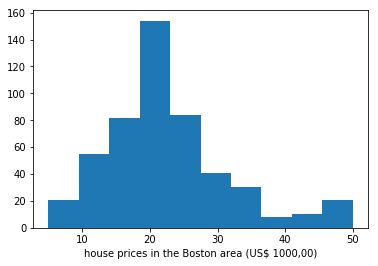

In [9]:
import pylab as plt

# see how the response variable is distrisbuted
plt.figure()
plt.hist(boston['target'])
plt.xlabel('house prices in the Boston area (US$ 1000,00)')
plt.show()

Since house prices are no-negative real numbers, we know that we are dealing with a **regression** problem.

The element `feature_names` stores labels for each feature.

In [15]:
# get the name of each variable in the feature space
boston['feature_names']

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], 
      dtype='<U7')

This does not say much.  
In the [dataset website](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html) we find a more verbose feature description:

CRIM - per capita crime rate by town  
ZN - proportion of residential land zoned for lots over 25,000 sq.ft.  
INDUS - proportion of non-retail business acres per town.  
CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)  
NOX - nitric oxides concentration (parts per 10 million)  
RM - average number of rooms per dwelling  
AGE - proportion of owner-occupied units built prior to 1940  
DIS - weighted distances to five Boston employment centres  
RAD - index of accessibility to radial highways  
TAX - full-value property-tax rate per $10,000  
PTRATIO - pupil-teacher ratio by town  
B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town  
LSTAT - % lower status of the population  

The `data` element contains the feature matrix as a 2-dimensional array. 

In [19]:
# check the dimensionality of the data matrix
boston['data'].shape

(506, 13)

We see that we are dealing with a multivariate regression problem with an original data matrix 

#### Define what problem you wish to tackle

Even though we have 13 features in our data we might not be interested in taking all of them into account. Maybe the dimensionality of the problem is too big, or the features are correlated - meaning they will provide basically the same information or maybe there are missing data. 

Let's take a look more closely in the individual features in order to understand if any of the above apply. 

In [32]:
# check the data quality of each feature
zeros = {}
for j in range(boston['data'].shape[1]):
    null = sum([item == 0. for item in boston['data'][:,j]])
    zeros[boston['feature_names'][j]] = null

print(zeros)

{'CRIM': 0, 'ZN': 372, 'INDUS': 0, 'CHAS': 471, 'NOX': 0, 'RM': 0, 'AGE': 0, 'DIS': 0, 'RAD': 0, 'TAX': 0, 'PTRATIO': 0, 'B': 0, 'LSTAT': 0}


From this we see that there is probably not much use in making inference with `ZN` and `CHAS` - since most of those values are null.  
There are machine learning algorithms which are able to deal with missing data or sparse matrices, however, we will not discusss them here.

Let's remove these 2 columns from the data matrix and take a look in the other features.

In [43]:
# get index of columns to be removed
indx_ZN = list(boston['feature_names']).index('ZN')
indx_CHAS = list(boston['feature_names']).index('CHAS')

# remove ZN and CHAS from feature matrix
data_clipped = np.delete(boston['data'], [indx_ZN, indx_CHAS], axis=1)

# check dimensionality of the resulting feature matrix
data_clipped.shape

(506, 11)

We can now visualize the remaining features.

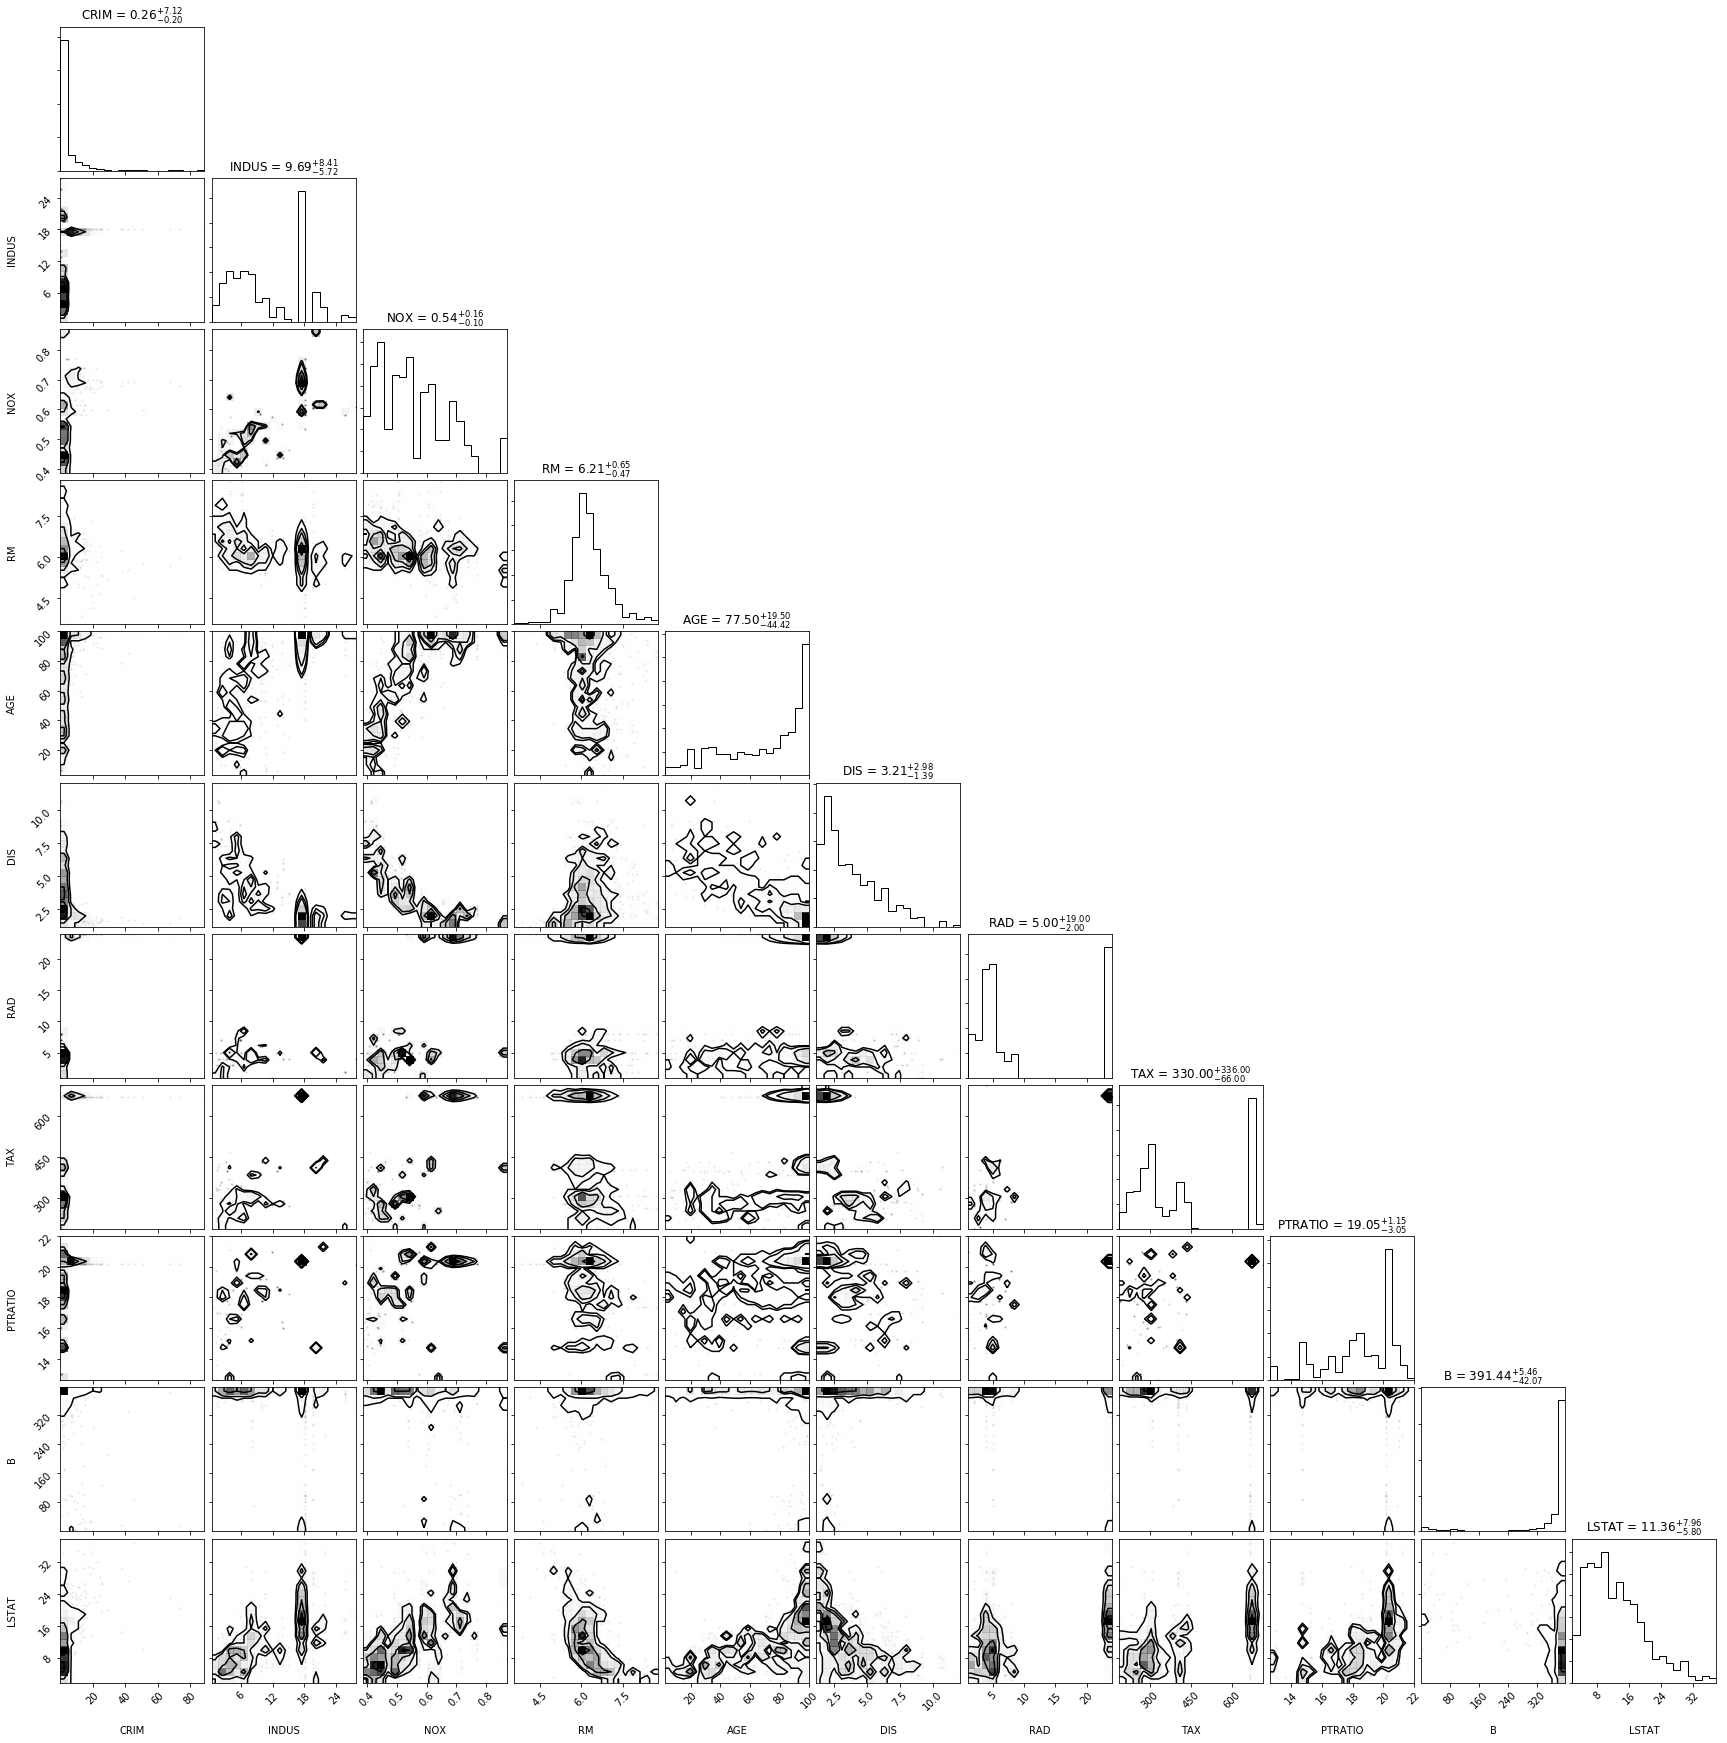

In [45]:
import corner

# plot every feature against each other
figure = corner.corner(data_clipped, labels=np.delete(boston['feature_names'], [indx_ZN, indx_CHAS]),
                       show_titles=True, title_kwargs={"fontsize": 12})

We can see that there is apparently no strong correlation between different features. Moreover, the distribution of the features themselve is not always well behaved.  

Let's choose the most well behaved features and investigate their correlation with the target (response) variable.  
From the plot, we see that `RM`, `AGE`, `DIS` and `LSTAT` have smooth distributions - so we will continue from here with them. 

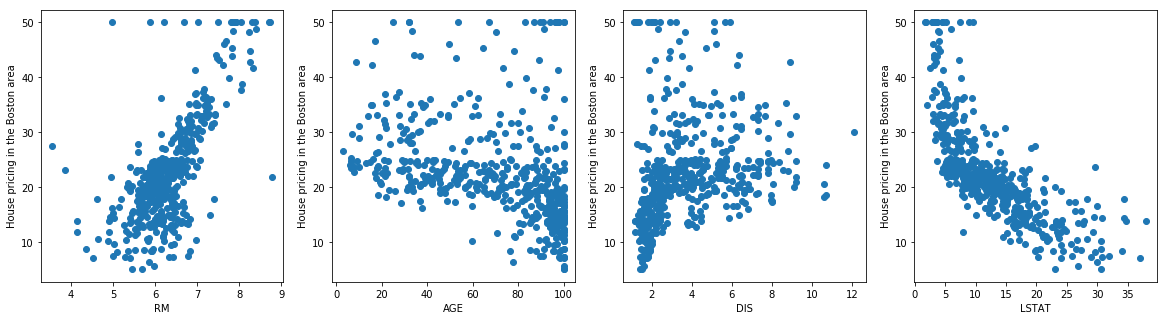

In [57]:
# get indexes for features of interest
feat_names = ['RM', 'AGE', 'DIS', 'LSTAT']

indx = [list(boston['feature_names']).index(item) for item in feat_names]

# plot these features as a function of the target variable
plt.figure(figsize=(20,5))
for i in range(len(feat_names)):
    plt.subplot(1, len(feat_names), i + 1)
    plt.scatter(boston['data'][:,indx[i]], boston['target'])
    plt.xlabel(feat_names[i])
    plt.ylabel('House pricing in the Boston area')
plt.show()    

At this point, our choice of giving the number of rooms (`RM`) as an example is more clear. Among the above plotted features, only `RM` and `LSTAT` show percivable correlations with the housing price. Even so, the correlation we can perceive in `LSTAT` does not seem to be linear.  

We shall continue with `RM`.

<div class="alert alert-info">

**IMPORTANT:** All the above arguments are really simplistic and do not take into account the correlations in the data. In a more realistic scenario, feature extraction should be performed in a more criterious way. This will be further investigated in the supernova photmetric classification problem.

</div>

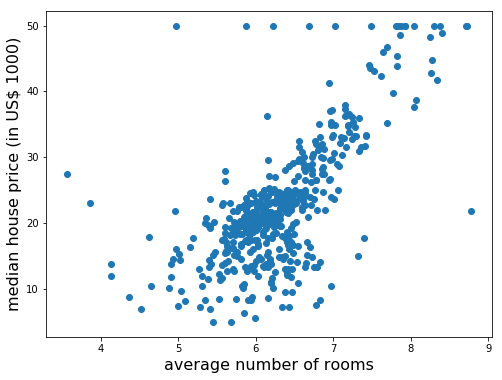

In [58]:
# closer look at the relation we are going to study
plt.figure(figsize=(8,6))
plt.scatter(boston['data'][:,5], boston['target'])
plt.xlabel('average number of rooms', fontsize=16)
plt.ylabel('median house price (in US$ 1000)', fontsize=16)
plt.show()

## Linear Fit

In [68]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Fit the model
regr.fit(boston['data'][:,5].reshape(-1,1), boston['target'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [69]:
# create vector for estimations
x_est = np.arange(min(boston['data'][:,5]), max((boston['data'][:,5])), 0.1)

# predict house prices
y_est = regr.predict(x_est.reshape(-1,1))

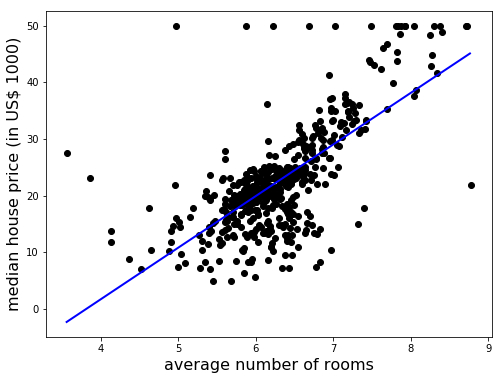

In [70]:
# Plot results
plt.figure(figsize=(8,6))
plt.scatter(boston['data'][:,5], boston['target'], color='black')
plt.plot(x_est, y_est, color='blue', lw=2)
plt.xlabel('average number of rooms', fontsize=16)
plt.ylabel('median house price (in US$ 1000)', fontsize=16)
plt.show()

In [ ]:
In order to get a measurement of how good the data is

## Evaluate the fit
    - Is this machine learning?
    - How do you evaluate the fit?
    - What is missing in this analysis?

## Separate samples

We need to evaluate the quality of the model in a sample that was not used for training!

In [82]:
from sklearn.model_selection import train_test_split

# randomly separates 1/3 of the sample for testing
X_train, X_test, y_train, y_test = train_test_split(boston['data'][:,indx_RM], 
                                                    boston['target'],test_size=0.33, random_state=42)

# Create linear regression object
regr2 = linear_model.LinearRegression()

# Train the model only in the training sample
regr2.fit(X_train.reshape(-1,1), y_train)

# Predict the house prices for the elements in the test set
y_est2 = regr2.predict(X_test.reshape(-1,1))

# Calculate goodness of fit
# this calculates R^2 - the closer to 1 the better
regr2.score(X_test.reshape(-1,1), y_test)


0.48345901689194898

------------------------------------------------------------------------------------------------------------------
Summary:

## Machine Learning Model          

**Task**:  Predict house prices in the Boston area  

       input: characteristics of the house and its neighborhood
       output: house price - positive real number  
       
**Task Category**:   Regression

**Data**: extraction from  [Boston housing prices dataset](http://lib.stat.cmu.edu/datasets/boston)  
        
        1 Feature, x vector
            RM       average number of rooms per dwelling  
    
        1 response variable (label), y    
            Median house price in US$ 1000,00
            
**Machine Learning category**:  

        Supervised Learning

**Set of possible samples**:  

        506 examples of 14 features each
        
**Set of possible labels**:

        positive real numbers
        
**Learner**:
    
        Linear Regression       
        
**Loss function**:

        Sum of squared residuals (Ordinary Least Square)